In [104]:
import pandas as pd
import numpy as np
import datetime
import vnquant.DataLoader as dl
import investpy
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style('whitegrid')
%matplotlib inline

In [105]:
StockList = pd.read_csv('StockList.csv',index_col='Ticker')

In [106]:
company_list = ['MWG','TCB','HSG']
num_of_shares = [100,400,200,]

In [107]:
#stock data
def load_stock_data(symbol):
    start = '2019-01-01'
    
    #you can fix the time frame by using timedelta function of datetime library
    now = datetime.datetime.now()
    end = now.strftime("%Y-%m-%d")
    loader = dl.DataLoader(symbol, start,end, data_source='VND', minimal=True)
    data = loader.download()
    data['PctChange'] = data.close.pct_change()
    data.dropna(inplace=True)
    
    if StockList.loc[symbol].values == 'HOSE':
        data = data[data['PctChange']>= -0.07]
    elif StockList.loc[symbol].values == 'HNX':
        data = data[data['PctChange']>= -0.10]
    else: 
        data = data[data['PctChange']>= -0.15]

    return data

#index data
def load_index_data(x):
    end = datetime.datetime.now()
    index =investpy.get_index_historical_data(x,country='vietnam',from_date='01/01/2019',to_date=end.strftime('%d/%m/%Y'))
    index = pd.DataFrame(index)
    index = index.drop(columns =['Currency'])
    index = index.reset_index()
    index = index.rename(columns={'Date':'date','Open':'open' ,'Close':'close','High':'high','Low':'low','Volume':'volume'})
    index = index.set_index('date')

    index['PctChangeIndex'] = index.close.pct_change()
    index.dropna(inplace = True)
    return index

In [108]:
d = {}
for name in company_list:
    d[name] = load_stock_data(name)
    

2022-06-05 17:22:31,981 : INFO : data MWG from 2019-01-01 to 2022-06-05 have already cloned!
2022-06-05 17:22:32,446 : INFO : data TCB from 2019-01-01 to 2022-06-05 have already cloned!
2022-06-05 17:22:32,809 : INFO : data HSG from 2019-01-01 to 2022-06-05 have already cloned!


In [109]:
data = d.copy()
#Slice to get needed data
for name in company_list:
    data[name] = data[name]['PctChange']




In [110]:
df_change = pd.DataFrame.from_dict(data)
df_change.dropna()

,MWG,TCB,HSG
date,,,
2019-01-03,-0.029240,-0.023438,-0.030960
2019-01-04,0.007229,-0.002000,-0.014377
2019-01-07,0.016746,0.006012,0.040519
2019-01-08,-0.011765,0.000000,0.003115
2019-01-09,0.016667,0.027888,0.040373
...,...,...,...
2022-05-30,-0.010225,0.008011,-0.006466
2022-05-31,-0.002066,-0.015894,-0.010846
2022-06-01,0.004141,-0.008075,-0.008772


In [111]:
#  #create dataframe from dictionary
# df_change = pd.DataFrame({name:list(pct_change) for name,pct_change in data.items()},dropna)
# df_change.dropna(inplace=True)
# #df_change



In [112]:
corr = df_change.corr()
corr.style.background_gradient(cmap='BrBG_r')

,MWG,TCB,HSG
MWG,1.000000,0.579462,0.400461
TCB,0.579462,1.000000,0.462911
HSG,0.400461,0.462911,1.000000


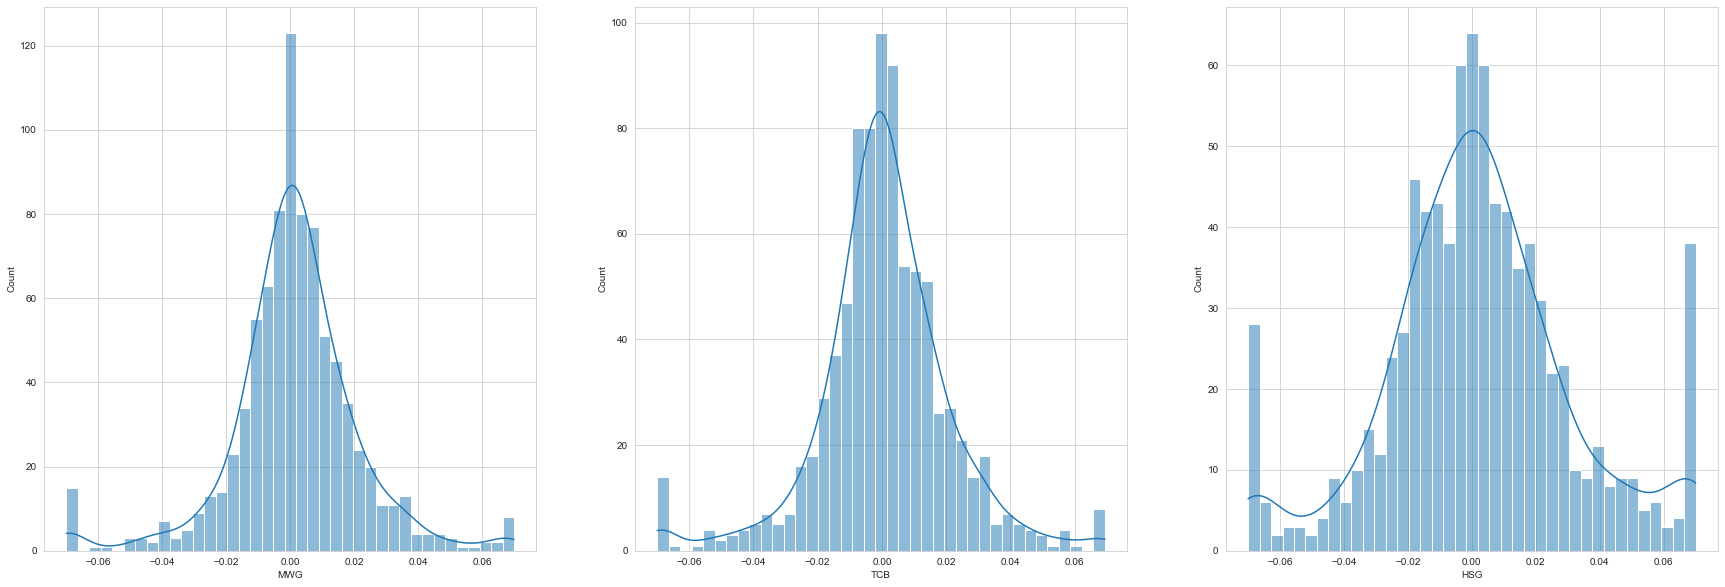

In [113]:
fig,axes = plt.subplots(1,len(company_list),figsize=(30,10))
# for name in company_list:
#sns.displot(data = df_change)
# df_change.VCI

for name,x in zip(company_list,range(len(company_list))):
    sns.histplot(data = df_change[name],ax=axes[x],kde=True,bins=39)
    #sns.lineplot(x=df_change[name], y=norm_cdf[name], ax=axes[1,x])


<AxesSubplot:>

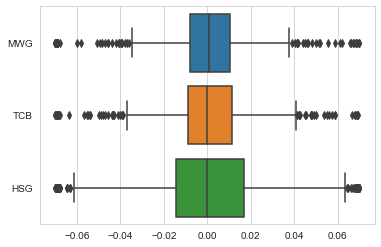

In [114]:
sns.boxplot(data = df_change,orient="h")

In [115]:
#sns.pairplot(df_change,kind='reg')

In [123]:
### Portfolio monitoring""")
lastestPrice = pd.DataFrame(columns=['Lastest Price', 'Number of Shares', 'Weight'], index=company_list)
i = 0
data = d.copy()
for name in company_list:
    x = float(data[name].close.iloc[-1].values)
    lastestPrice['Lastest Price'].iloc[i] = x
    i += 1

lastestPrice['Number of Shares'] = num_of_shares
for i in range(len(company_list)):
    lastestPrice['Weight'].iloc[i] = round(
        (lastestPrice['Number of Shares'].iloc[i] * lastestPrice['Lastest Price'].iloc[i]) / sum(
            lastestPrice['Number of Shares'] * lastestPrice['Lastest Price']), 4)
portfolio = pd.DataFrame(index=company_list, columns=['Weight', 'Beta', 'Adjbeta', 'Std'])
portfolio.Weight = lastestPrice.Weight

/Users/haquochung/opt/anaconda3/envs/CV_portfolio/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [124]:
portfolio = pd.DataFrame(index = company_list, columns = ['Weight','Beta','Adjbeta','Std'])
portfolio.Weight = lastestPrice.Weight
portfolio

,Weight,Beta,Adjbeta,Std
MWG,0.4464,NaN,NaN,NaN
TCB,0.4248,NaN,NaN,NaN
HSG,0.1288,NaN,NaN,NaN


In [125]:
### Using the riskanalysis class from the risk analysis section
class risk_analysis(object):
    def __init__(self, stock_name, index_name, start_date):
        self.stock_name = stock_name
        self.index_name = index_name
        self.start_date = start_date



    def get_data_stock(self,stock_name, start_date):
        start_date = start_date
        end_date = datetime.datetime.today().strftime('%Y-%m-%d')
        loader = dl.DataLoader(stock_name , start_date, end_date, data_source='VND', minimal=True)
        data = loader.download()
        return data



    def get_index_data(self,index_name, start_date):
        start_date = datetime.datetime.strptime(start_date,'%Y-%m-%d').strftime('%d/%m/%Y')
        end_date = datetime.datetime.today().strftime('%d/%m/%Y')

        index = investpy.get_index_historical_data(index_name,country='vietnam',from_date=start_date,to_date=end_date)

        return index

    def data_collection(self):

        # Get index data
        index = self.get_index_data(self.index_name, self.start_date)
        index_data = index.reset_index()
        index_data = index_data.rename(columns={'Date':'date','Open':'open' ,'Close':'close','High':'high','Low':'low','Volume':'volume'})
        index_data['date'] = pd.to_datetime(index_data['date'])
        index_data = index_data.set_index('date')
        index_data = index_data.drop('Currency', axis=1)
        index_data['pctchange'] = index_data['close'].pct_change()
        index_data.dropna(inplace=True)


        # Get stock data
        stock = self.get_data_stock(self.stock_name, self.start_date)
        stock_data = stock.reset_index()
        stock_data = stock_data.rename(columns={'Date':'date', 'Close':'close'})
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data = stock_data.set_index('date')
        stock_data = stock_data[['open','high','low','close','volume']]
        stock_data['pctchange'] = stock_data['close'].pct_change()
        stock_data.dropna(inplace=True)

        self.index_data = index_data
        self.stock_data = stock_data

        return self.index_data, self.stock_data

    def calculate_std(self):
        index_data, stock_data = self.index_data, self.stock_data

        # Calculate variance
        #var_stock = round(float(['pctchange'].var()),5)
        # Calculate standard deviation
        def variance(data, ddof=0):
            n = len(data)
            mean = sum(data) / n

            return sum((x - mean) ** 2 for x in data) / (n - ddof)

        var_stock = round(variance(stock_data['pctchange']),5)
        var_stock = var_stock * 100

        stock_variance = 'Variance: ' + str(var_stock).format('.2f') + '%'

        std_stock = round(float(stock_data['pctchange'].std()),5)
        std_stock = std_stock * 100
        stock_std_deviation = 'Standard deviation: ' + str(std_stock).format('.2f') + '%'

        return std_stock

    def calculate_beta(self):
        index_data, stock_data = self.data_collection()

        # Calculate beta
        def beta(data, data_index):
            return np.cov(data, data_index)[0, 1] / np.var(data_index)

        beta_stock = beta(stock_data['pctchange'], index_data['pctchange'])
        beta_stock = round(beta_stock,5)

  

        return beta_stock

    def calculate_alpha(self):
        index_data, stock_data = self.data_collection()
        def beta(data, data_index):
            return np.cov(data, data_index)[0, 1] / np.var(data_index)

        # Calculate alpha
        def alpha(data, data_index):
            return np.mean(data) - beta(data, data_index) * np.mean(data_index)

        alpha_stock = alpha(stock_data['pctchange'], index_data['pctchange'])
        alpha_stock = round(alpha_stock,5) *100

        stock_alpha = 'Alpha: ' + str(alpha_stock).format('.2f') + '%'

        return alpha_stock

    def calculate_rsquared(self):
        index_data, stock_data = self.data_collection()

        # Calculate rsquared
        def rsquared(data, data_index):
            return 1 - (np.var(data) / np.var(data_index))

        rsquared_stock = rsquared(stock_data['pctchange'], index_data['pctchange'])
        rsquared_stock = round(rsquared_stock,5)

        stock_rsquared = 'Rsquared: ' + str(rsquared_stock).format('.2f')

        return rsquared_stock

    def calculate_correlation(self):
        index_data, stock_data = self.data_collection()

        # Calculate correlation
        def correlation(data, data_index):
            return np.corrcoef(data, data_index)[0, 1]

        correlation_stock = correlation(stock_data['pctchange'], index_data['pctchange'])
        correlation_stock = round(correlation_stock,5)

        stock_correlation = 'Correlation: ' + str(correlation_stock).format('.2f')

        return correlation_stock

In [126]:
#Collecting data and calculate beta for each symbol
index = 'VN'
start = '2020-01-01' 
#create dictionary for company's beta
Risk_indicator = {}
for name in company_list:
    company = risk_analysis(name,index, start)
    beta = float(company.calculate_beta())
    std = float(company.calculate_std())
    Risk_indicator[name] = beta  ,std
x = Risk_indicator.copy()
df_risk = pd.DataFrame.from_dict(Risk_indicator,orient='index',columns=['Beta','Std'])
df_risk

2022-06-05 17:22:58,893 : INFO : data MWG from 2020-01-01 to 2022-06-05 have already cloned!
2022-06-05 17:22:59,596 : INFO : data TCB from 2020-01-01 to 2022-06-05 have already cloned!
2022-06-05 17:23:00,268 : INFO : data HSG from 2020-01-01 to 2022-06-05 have already cloned!


,Beta,Std
MWG,1.08370,2.608
TCB,1.28879,2.295
HSG,1.34195,3.146


In [127]:
portfolio['Beta'] = df_risk.Beta.values
portfolio['Adjbeta'] = portfolio['Beta']*portfolio['Weight']
portfolio['Std'] = df_risk.Std.values
portfolio


,Weight,Beta,Adjbeta,Std
MWG,0.4464,1.08370,0.483764,2.608
TCB,0.4248,1.28879,0.547478,2.295
HSG,0.1288,1.34195,0.172843,3.146


In [128]:
returns = df_change
returns.dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
matrix = returns.dot(portfolio.Weight)
matrix

date
2019-01-03   -0.026996
2019-01-04    0.000526
2019-01-07    0.015248
2019-01-08   -0.004851
2019-01-09    0.024487
                ...   
2022-05-30   -0.001994
2022-05-31   -0.009071
2022-06-01   -0.002712
2022-06-02   -0.003852
2022-06-03    0.019884
Length: 852, dtype: object

In [129]:
portfolio_beta = round(portfolio['Adjbeta'].sum(),4)
portfolio_std = round(np.sqrt(100* np.dot(portfolio.Weight.T, np.dot(cov_matrix*250, portfolio.Weight))),4)

print('Portfolio beta: '+str(portfolio_beta).format('.2f'))
print('Portfolio standard deviation:'+str(portfolio_std).format('.2f') + '%')

Portfolio beta: 1.2041
Portfolio standard deviation:2.8265%


## Value at Risk (VaR)

In [61]:
returns = df_change
returns.dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
returns['portfolio'] = returns.dot(portfolio.Weight)
returns

ValueError: matrices are not aligned

In [59]:
# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")
        
def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")


In [60]:
from scipy.stats import norm,t

def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR


def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [102]:
port_return, port_std = portfolioPerformance(portfolio.Weight,mean_returns,cov_matrix,365)
var_parametric(port_return,port_std,distribution='normal')

0.155778931726762

In [103]:
cvar_parametric(port_return,port_std)


0.2984897275970176

In [104]:
# Monte Carlo Method
mc_sims = 300 # number of simulations
T = 252 #timeframe in days

meanM = np.full(shape=(T, len(portfolio.Weight)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 100000000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(portfolio.Weight)))
    L = np.linalg.cholesky(cov_matrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(portfolio.Weight, dailyReturns.T)+1)*initialPortfolio
    
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR {} VND'.format(round(VaR,2)))
print('CVaR {} VND'.format(round(CVaR,2)))

VaR 21688018.73 VND
CVaR 28190395.84 VND


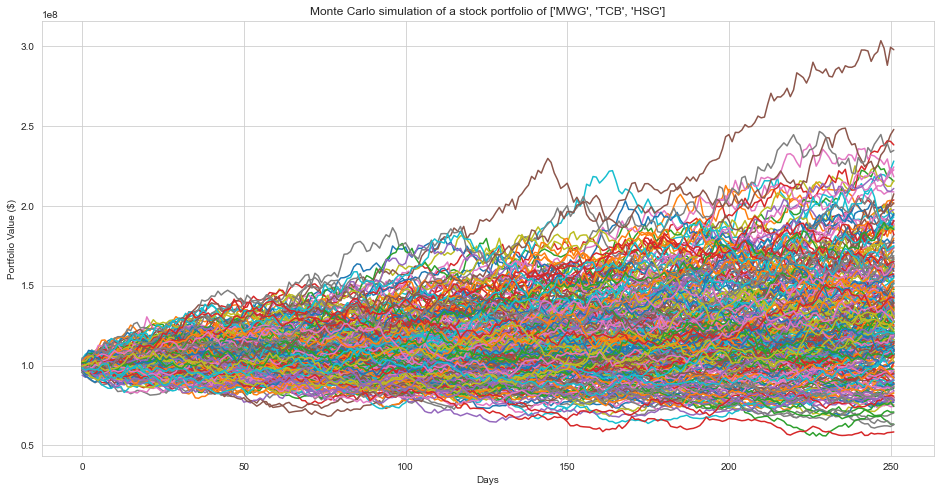

In [105]:
fig,axes = plt.subplots(1,1,figsize = (16,8))
fig = plt.plot(portfolio_sims)
axes.set_xlabel('Days')
axes.set_ylabel('Portfolio Value ($)')
axes = plt.title('Monte Carlo simulation of a stock portfolio of ' + str(company_list))
plt.show()

In [21]:
import vnquant.DataLoader as dl
import pandas as pd
import numpy as np
import datetime
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply
from backtesting.test import SMA


/Users/haquochung/opt/anaconda3/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [22]:
def load_stock_data(symbol):
    start = '2020-01-01'
    
    #you can fix the time frame by using timedelta function of datetime library
    now = datetime.datetime.now()
    end = now.strftime("%Y-%m-%d")
    loader = dl.DataLoader(symbol, start,end, data_source='VND', minimal=True)
    pricedata = loader.download()
    
    #format the data for the mplfinance
    stock = pricedata.copy()
    stock.reset_index(inplace = True)

    dailyInfo = pd.DataFrame( columns =['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    dailyInfo['Date'] = stock['date']
    dailyInfo['Open'] = stock['open']
    dailyInfo['High'] = stock['high']
    dailyInfo['Low'] = stock['low']
    dailyInfo['Close'] = stock['close']
    dailyInfo['Volume'] = stock['volume']
    dailyInfo.set_index('Date', inplace= True)
    
    #to store data remove the '#' on the following line
    #csv_file = close_data.to_csv(f'Data/ClosePrice/{symbol} historical since {start}', index=True)

    return dailyInfo

In [23]:
#Simple backtesting using backtesting.py
#simple sma backtest
for name in company_list:
    stock = load_stock_data(name)
    
        #Bollinger band
    def BBupper(array,n):
        B_MA = pd.Series(array).rolling(n).mean()
        sigma = pd.Series(array).rolling(n).std() 

        BU = pd.Series((B_MA + 2 * sigma), name='BU')
        return BU

    def BBlower(array,n):
        B_MA = pd.Series(array).rolling(n).mean()
        sigma = pd.Series(array).rolling(n).std() 

        BL = pd.Series((B_MA - 2 * sigma), name='BL')    
        return BL


    class SmaCross(Strategy):
        n1 = 20
        n2 = 60

        def init(self):
            close = self.data.Close
            self.sma1 = self.I(SMA, close, self.n1)
            self.sma2 = self.I(SMA, close, self.n2)
            self.upperband = self.I(BBupper, close, 20)
            self.lowerband = self.I(BBlower, close, 20)

        def next(self):
            if crossover(self.sma1, self.sma2):
                self.buy()
            elif crossover(self.sma2, self.sma1):
                self.sell()


    bt = Backtest(stock, SmaCross,
                  cash=10000, commission=.007,
                  exclusive_orders=True)

    output = bt.run()
    bt.plot()

2022-06-05 08:47:50,731 : INFO : data MWG from 2020-01-01 to 2022-06-05 have already cloned!


2022-06-05 08:47:51,416 : INFO : data TCB from 2020-01-01 to 2022-06-05 have already cloned!


2022-06-05 08:47:52,006 : INFO : data HSG from 2020-01-01 to 2022-06-05 have already cloned!


2022-06-05 08:47:52,680 : INFO : data IDC from 2020-01-01 to 2022-06-05 have already cloned!


2022-06-05 08:47:53,607 : INFO : data BSR from 2020-01-01 to 2022-06-05 have already cloned!


In [26]:
#backtesting sma and rsi

def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

#Bollinger band
def BBupper(array,n):
    B_MA = pd.Series(array).rolling(n).mean()
    sigma = pd.Series(array).rolling(n).std() 
    
    BU = pd.Series((B_MA + 2 * sigma), name='BU')
    return BU

def BBlower(array,n):
    B_MA = pd.Series(array).rolling(n).mean()
    sigma = pd.Series(array).rolling(n).std() 
    
    BL = pd.Series((B_MA - 2 * sigma), name='BL')    
    return BL

for name in company_list:
    stock = load_stock_data(name)
    class System(Strategy):
        d_rsi = 30  # Daily RSI lookback periods
        w_rsi = 30  # Weekly
        level = 70

        def init(self):
            # Compute moving averages the strategy demands
            self.ma10 = self.I(SMA, self.data.Close, 10)
            self.ma20 = self.I(SMA, self.data.Close, 20)
            self.ma50 = self.I(SMA, self.data.Close, 50)
            self.ma100 = self.I(SMA, self.data.Close, 100)

            # Compute daily RSI(30)
            self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)

            # To construct weekly RSI, we can use `resample_apply()`
            # helper function from the library
            self.weekly_rsi = resample_apply(
                'W-FRI', RSI, self.data.Close, self.w_rsi)
            
            #Bollingerband
            self.upperband = self.I(BBupper, self.data.Close, 20)
            self.lowerband = self.I(BBlower, self.data.Close, 20)

        def next(self):
            price = self.data.Close[-1]

            # If we don't already have a position, and
            # if all conditions are satisfied, enter long.
            if (not self.position and
                self.daily_rsi[-1] > self.level and
                self.weekly_rsi[-1] > self.level and
                self.weekly_rsi[-1] > self.daily_rsi[-1] and
                self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
                price > self.ma10[-1]):

                # Buy at market price on next open, but do
                # set 8% fixed stop loss.
                self.buy(sl=.92 * price)

            # If the price closes 2% or more below 10-day MA
            # close the position, if any.
            elif price < .98 * self.ma10[-1]:
                self.position.close()


    backtest = Backtest(stock, System, commission=.002)
    backtest.run()



    backtest.optimize(d_rsi=range(10, 35, 5),
                      w_rsi=range(10, 35, 5),
                      level=range(30, 80, 10))

    backtest.plot()
    #print(backtest)

2022-05-25 09:41:51,164 : INFO : data NT2 from 2020-01-01 to 2022-05-25 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


2022-05-25 09:41:59,143 : INFO : data TCB from 2020-01-01 to 2022-05-25 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


2022-05-25 09:42:06,372 : INFO : data HSG from 2020-01-01 to 2022-05-25 have already cloned!
/Users/haquochung/opt/anaconda3/envs/VietnamStockMarket/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [27]:
company_list


['NT2', 'TCB', 'HSG']

In [28]:
d = {}
for name in company_list:
    d[name] = load_data(name)
    
x = d.copy()

2022-05-25 09:42:14,695 : INFO : data NT2 from 2020-01-01 to 2022-05-25 have already cloned!
2022-05-25 09:42:15,037 : INFO : data TCB from 2020-01-01 to 2022-05-25 have already cloned!
2022-05-25 09:42:15,418 : INFO : data HSG from 2020-01-01 to 2022-05-25 have already cloned!


In [29]:
for name in company_list:
    x[name]['Pctchange'] = x[name].close.pct_change()
    x[name]['Cum_return'] = (d[name]['Pctchange'] + 1).cumprod()
    x[name].dropna(inplace=True)


In [33]:
cum_returns = {}
for name in company_list:
    cum_returns[name]= x[name]['Cum_return']
    
cum_returns = pd.DataFrame.from_dict(cum_returns)
print(cum_returns)
for name in company_list:
    cum_returns[name] = portfolio['Weight'][name] *cum_returns[name]

cum_returns['Portfolio'] =  cum_returns.sum(axis = 1)
cum_returns = pd.DataFrame(cum_returns['Portfolio'])


                 NT2       TCB       HSG
date                                    
2020-01-03  0.986207  0.993697  0.974359
2020-01-06  0.983908  0.968487  0.979243
2020-01-07  0.983908  0.974790  0.968254
2020-01-08  0.942529  0.955882  0.960928
2020-01-09  0.910345  0.968487  0.987790
...              ...       ...       ...
2022-05-09  0.963218  1.621849  2.954823
2022-05-10  0.995402  1.626050  3.003663
2022-05-11  1.022989  1.638655  2.991453
2022-05-12  0.965517  1.525210  2.783883
2022-05-13  0.924138  1.420168  2.594628

[587 rows x 3 columns]


In [34]:
index = load_index_data('VN')
index['Pctchange'] = index.Close.pct_change()
index['Cum_return'] = (index['Pctchange'] + 1).cumprod()
index.dropna(inplace=True)
index_cum = index.Cum_return
#cum_returns['index'] = index_cum.values
cum_returns['index'] = index_cum.values

ValueError: Length of values (837) does not match length of index (587)

In [ ]:
cum_returns.reset_index(inplace=True)

In [ ]:
import pandas as pd
import vnquant.DataLoader as dl
import datetime
import investpy
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

fig = px.line(cum_returns, x="date", y=cum_returns.columns,hover_data={"date": "|%B %d, %Y"})
fig.update_xaxes(dtick="M1",
        tickformat="%b\n%Y",
        ticklabelmode="period"
        )
fig.show()

### Monte carlo simulation

In [8]:
from vnquant.DataLoader import DataLoader

loader = DataLoader(symbols="HNX30",
           start="2019-01-01",
           end="2020-08-09",
           minimal=False,
         data_source="vnd")

data = loader.download()

KeyError: "None of [Index(['date', 'adClose', 'close', 'pctChange', 'average', 'nmVolume',\n       'nmValue', 'ptVolume', 'ptValue', 'open', 'high', 'low'],\n      dtype='object')] are in the [columns]"

In [31]:
data

Attributes,high,low,open,close,avg,volume
Symbols,E1VFVN30,E1VFVN30,E1VFVN30,E1VFVN30,E1VFVN30,E1VFVN30
date,,,,,,
2019-01-02,14.33,14.06,14.30,14.10,14.16,2386440.0
2019-01-03,14.07,13.76,14.00,13.93,13.83,1474710.0
2019-01-04,13.92,13.57,13.60,13.92,13.63,1050810.0
2019-01-07,14.15,13.96,14.00,13.98,14.04,1698490.0
2019-01-08,14.50,13.88,14.50,14.10,13.92,914990.0
...,...,...,...,...,...,...
2020-08-03,12.62,12.45,12.60,12.62,12.54,771410.0
2020-08-04,12.90,12.65,12.90,12.90,12.73,116730.0
